# Imports and Settings

In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Dataset

In [6]:
transform = T.Compose(
    [T.Resize(224), 
     T.RandomHorizontalFlip(),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     T.Lambda(lambda x: x + torch.rand_like(x)* 0.1)
     ])
train_dataset = torchvision.datasets.ImageFolder(root='./train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./test', transform=transform)

In [30]:
len(train_dataset)

12845

In [31]:
len(test_dataset)

4268

In [32]:
batch_size = 32

In [33]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [34]:
image_datasets = {'train': train_dataset, 'val': train_dataset}
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(train_dataset)}

In [35]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [36]:
!pip install livelossplot --quiet

# Train and Eval Boilerplate

In [14]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from livelossplot import PlotLosses
import copy
import time

In [15]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=10):
    model = model.to(device)
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc_top5 = 0.0

    train_loss = []
    test_loss = []
    train_acc_top1 = []
    test_acc_top1 = []
    train_acc_top5 = []
    test_acc_top5 = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects_top1 = 0
            running_corrects_top5 = 0

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.topk(outputs, k=5, dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects_top1 += torch.sum(preds[:, 0] == labels)
                running_corrects_top5 += torch.sum(preds == labels.unsqueeze(1))
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)), end="")

#                 print( (i+1)*100. / len(dataloaders[phase]), "% Complete" )
                # sys.stdout.flush()
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc_top1 = running_corrects_top1.double() / dataset_sizes[phase]
            epoch_acc_top5 = running_corrects_top5.double() / dataset_sizes[phase]
            if phase == 'train':
                avg_loss = epoch_loss
                t_acc_top1 = epoch_acc_top1
                t_acc_top5 = epoch_acc_top5
            else:
                val_loss = epoch_loss
                val_acc_top1 = epoch_acc_top1
                val_acc_top5 = epoch_acc_top5
            
#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc_top5 > best_acc_top5:
                best_acc_top5 = epoch_acc_top5
                best_model_wts = copy.deepcopy(model.state_dict())

        train_loss.append(avg_loss)
        test_loss.append(val_loss)
        train_acc_top1.append(t_acc_top1.item())
        test_acc_top1.append(val_acc_top1.item())
        train_acc_top5.append(t_acc_top5.item())
        test_acc_top5.append(val_acc_top5.item())

        logs = {
            'loss': avg_loss,
            'val_loss': val_loss,
            'Top-1 accuracy': t_acc_top1.item(),
            'val_Top-1 accuracy': val_acc_top1.item(),
            'Top-5 accuracy': t_acc_top5.item(),
            'val_Top-5 accuracy': val_acc_top5.item()
        }
        liveloss.update(logs)
        liveloss.send()

        print('Train Loss: {:.4f} Top-1 Acc: {:.4f} Top-5 Acc: {:.4f}'.format(avg_loss, t_acc_top1, t_acc_top5))
        print(  'Val Loss: {:.4f} Top-1 Acc: {:.4f} Top-5 Acc: {:.4f}'.format(val_loss, val_acc_top1, val_acc_top5))
        print('Best Val Top-5 Accuracy: {}'.format(best_acc_top5))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Top-5 Acc: {:4f}'.format(best_acc_top5))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, test_loss, train_acc_top1, test_acc_top1, train_acc_top5, test_acc_top5 

Finetuning on Resnet18 

In [16]:
model_resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_classes = 27
for param in model_resnet18.parameters():
  param.require_grad = False
model_resnet18.fc = torch.nn.Linear(512, num_classes)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_resnet18 = model_resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/anvisa/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 8.83MB/s]


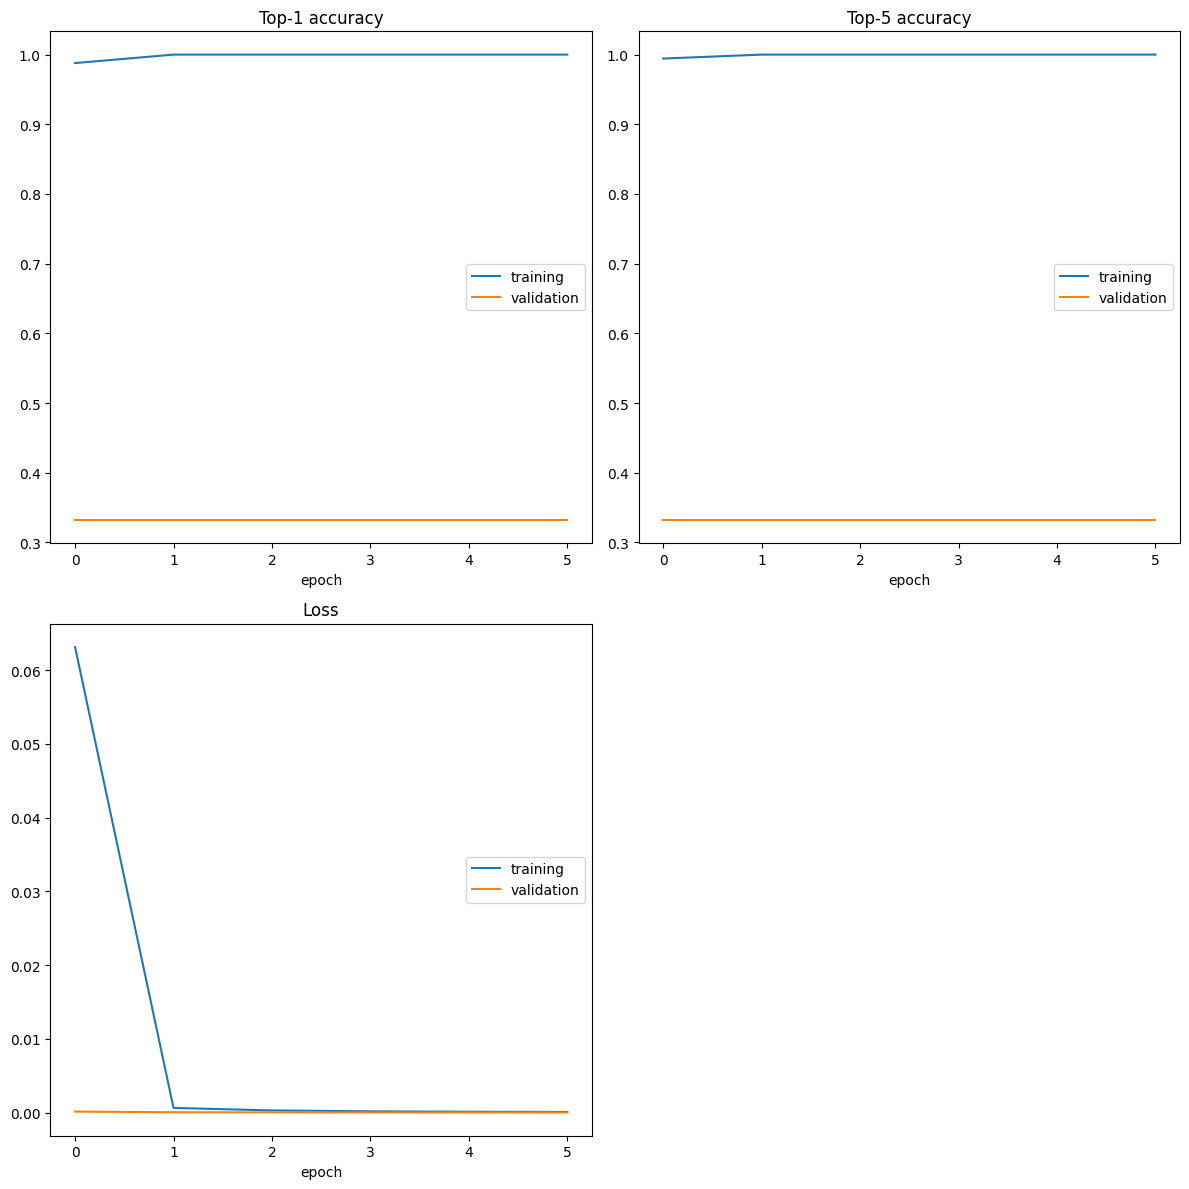

Top-1 accuracy
	training         	 (min:    0.988, max:    1.000, cur:    1.000)
	validation       	 (min:    0.332, max:    0.332, cur:    0.332)
Top-5 accuracy
	training         	 (min:    0.994, max:    1.000, cur:    1.000)
	validation       	 (min:    0.332, max:    0.332, cur:    0.332)
Loss
	training         	 (min:    0.000, max:    0.063, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Train Loss: 0.0001 Top-1 Acc: 1.0000 Top-5 Acc: 1.0000
Val Loss: 0.0000 Top-1 Acc: 0.3323 Top-5 Acc: 0.3323
Best Val Top-5 Accuracy: 0.3322693655118723

Epoch 7/10
----------
Iteration: 3/402, Loss: 0.004647394176572561.

KeyboardInterrupt: ignored

In [ ]:
best_model_10_epochs, train_loss, test_loss, train_acc_top1, test_acc_top1, train_acc_top5, test_acc_top5 = train_model(model_resnet18, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=10)

In [ ]:
torch.save(model_resnet18.state_dict(), '/content/gdrive/MyDrive/DL_Embedded_Project/Model Weights/Resnet 18/resnet_18_base.pth')

In [ ]:
## Eval function

## Model CNN

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 80, kernel_size = 5)
        self.conv2 = nn.Conv2d(80, 80, kernel_size = 5)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.batch_norm1 = nn.BatchNorm2d(80)
        self.batch_norm2 = nn.BatchNorm2d(80)

        self.fc1 = nn.Linear(224720, 256)
        self.fc2 = nn.Linear(256, 27)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view(-1, 224720)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x


In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_cnn = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_cnn = model_cnn.to(device)

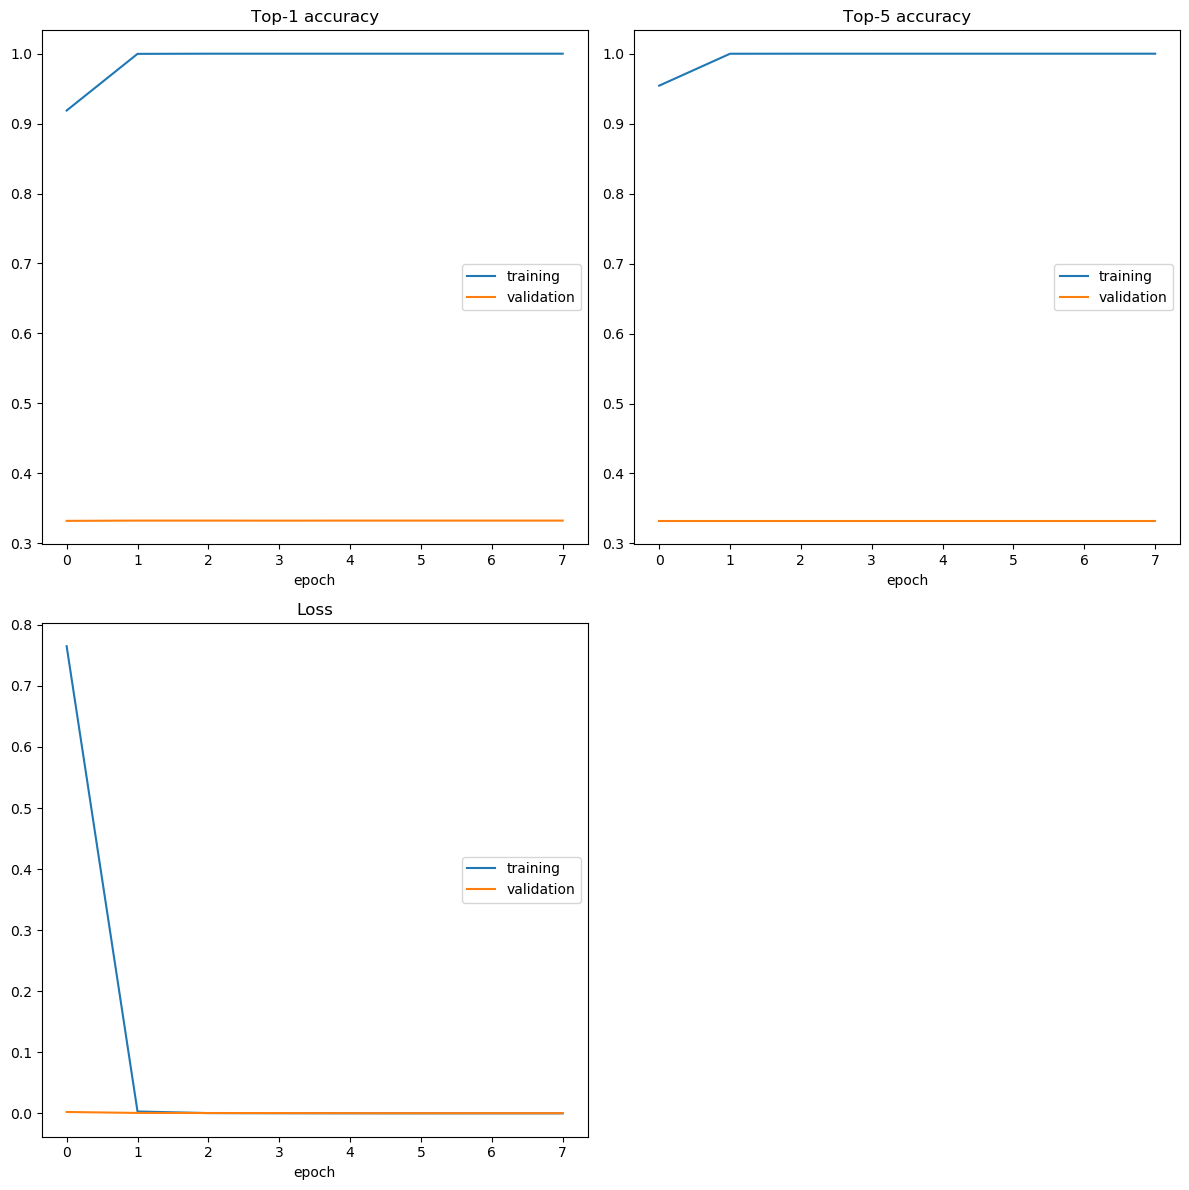

Top-1 accuracy
	training         	 (min:    0.919, max:    1.000, cur:    1.000)
	validation       	 (min:    0.332, max:    0.332, cur:    0.332)
Top-5 accuracy
	training         	 (min:    0.954, max:    1.000, cur:    1.000)
	validation       	 (min:    0.332, max:    0.332, cur:    0.332)
Loss
	training         	 (min:    0.000, max:    0.765, cur:    0.000)
	validation       	 (min:    0.000, max:    0.002, cur:    0.000)
Train Loss: 0.0001 Top-1 Acc: 1.0000 Top-5 Acc: 1.0000
Val Loss: 0.0003 Top-1 Acc: 0.3322 Top-5 Acc: 0.3323
Best Val Top-5 Accuracy: 0.3322693655118723

Epoch 9/10
----------
Iteration: 140/402, Loss: 0.0026606270112097263.Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/anvisa/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_163671/1793598235.py", line 1, in <module>
    best_model_10_epochs, train_loss, test_loss, train_acc_top1, test_acc_top1, train_acc_top5, test_acc_top5 = train_model(model_cnn, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=10)
  File "/tmp/ipykernel_163671/4269606319.py", line 52, in train_model
    running_loss += loss.item() * inputs.size(0)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/anvisa/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/anvisa/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1310, in stru

In [25]:
best_model_10_epochs, train_loss, test_loss, train_acc_top1, test_acc_top1, train_acc_top5, test_acc_top5 = train_model(model_cnn, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=10)

Densenet121

In [37]:
# Load the pre-trained DenseNet-121 model_dense
model_dense = models.densenet121(pretrained=False).to(device)

# Modify the last fully connected layer to output 27 classes instead of 1000
num_ftrs = model_dense.classifier.in_features
model_dense.classifier = torch.nn.Linear(num_ftrs, 27)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [38]:
model_dense

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

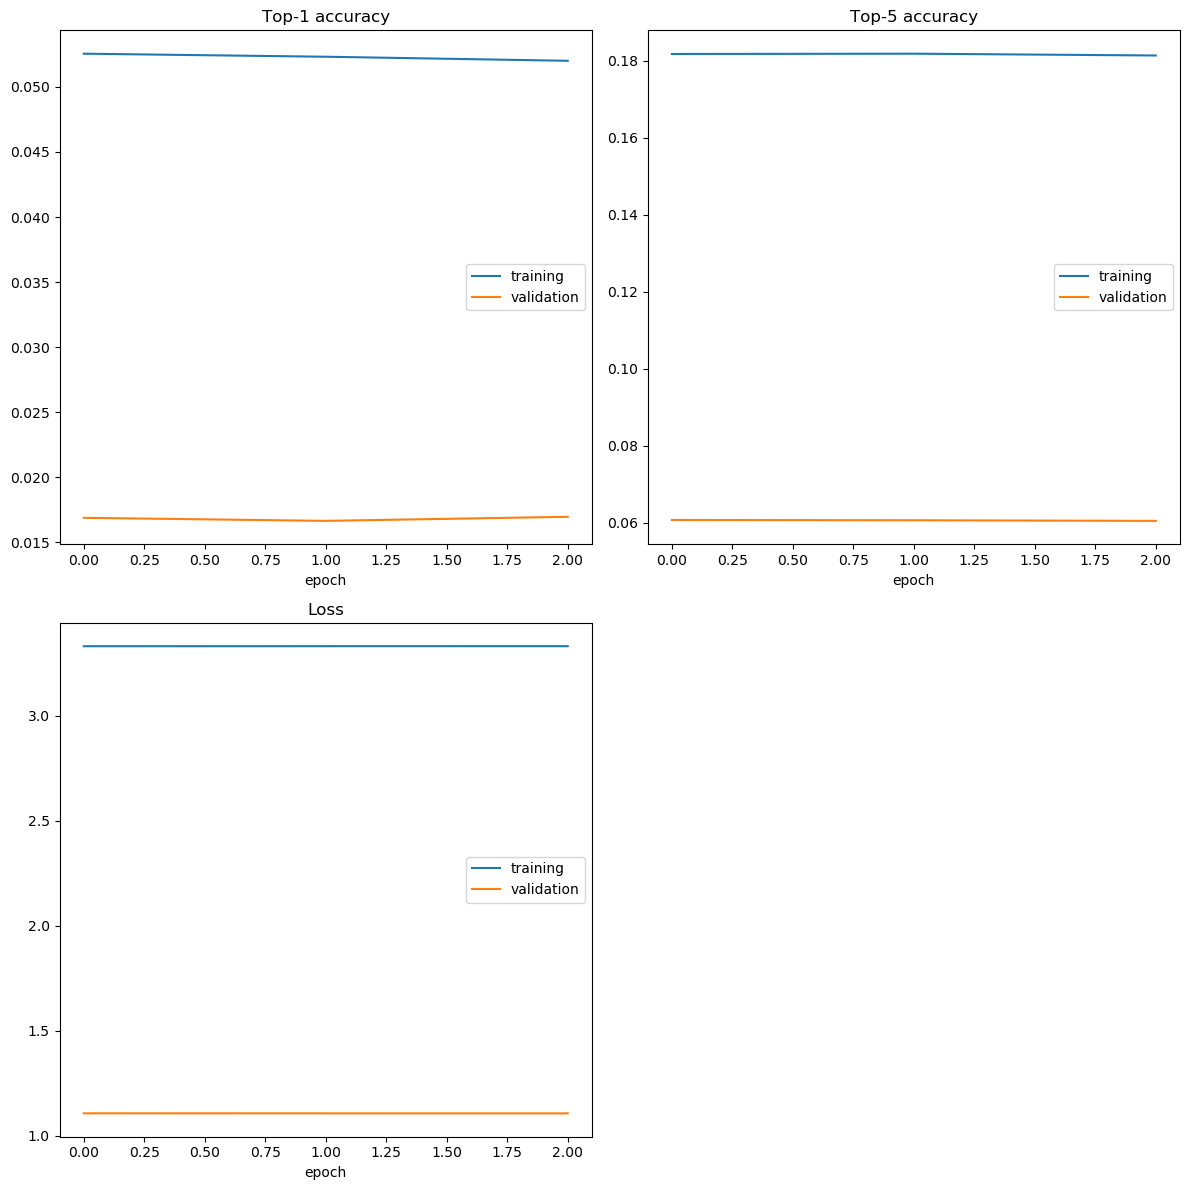

Top-1 accuracy
	training         	 (min:    0.052, max:    0.053, cur:    0.052)
	validation       	 (min:    0.017, max:    0.017, cur:    0.017)
Top-5 accuracy
	training         	 (min:    0.181, max:    0.182, cur:    0.181)
	validation       	 (min:    0.060, max:    0.061, cur:    0.060)
Loss
	training         	 (min:    3.330, max:    3.331, cur:    3.331)
	validation       	 (min:    1.107, max:    1.107, cur:    1.107)
Train Loss: 3.3306 Top-1 Acc: 0.0520 Top-5 Acc: 0.1814
Val Loss: 1.1068 Top-1 Acc: 0.0170 Top-5 Acc: 0.0605
Best Val Top-5 Accuracy: 0.06072401712728688

Epoch 4/10
----------
Iteration: 68/402, Loss: 106.82180786132812.Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/anvisa/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_163671/3181608913.py", line 1, in <module>
    best_model_10_epochs, train_loss, test_loss, train_acc_top1, test_acc_top1, train_acc_top5, test_acc_top5 = train_model(model_dense, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=10)
  File "/tmp/ipykernel_163671/4269606319.py", line 52, in train_model
    running_loss += loss.item() * inputs.size(0)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/anvisa/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/anvisa/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1310, in st

In [39]:
best_model_10_epochs, train_loss, test_loss, train_acc_top1, test_acc_top1, train_acc_top5, test_acc_top5 = train_model(model_dense, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=10)

# Torchscript Scripting

In [ ]:
import time
import os

def evaluate_model(model, testloader, model_name):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Evaluate unscripted model on test dataset
    unscripted_results = []
    with torch.no_grad():
        start = time.time()
        for images, labels in testloader:
            images = images.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            unscripted_results.append(predicted.tolist())
        end = time.time()
        avg_time_unscripted = (end - start) / 100
        print("Average execution time for unscripted model: {:.6f} s".format(avg_time_unscripted))

    # Export model to TorchScript format and evaluate on test dataset
    scripted_model = torch.jit.script(model)
    scripted_model = scripted_model.to(device)
    scripted_results = []
    with torch.no_grad():
        start = time.time()
        for images, labels in testloader:
            images = images.to(device)
            outputs = scripted_model(images)
            predicted = torch.argmax(outputs, 1)
            scripted_results.append(predicted.tolist())
        end = time.time()
        avg_time_scripted = (end - start) / 100
        print("Average execution time for scripted model: {:.6f} s".format(avg_time_scripted))

    # Compare results between unscripted and scripted models
    num_correct = 0
    for unscripted_pred, scripted_pred in zip(unscripted_results, scripted_results):
        if unscripted_pred == scripted_pred:
            num_correct += 1

    accuracy = num_correct / len(testloader.dataset)

    # Save TorchScript model
    scripted_model_file = model_name + '_scripted.pt'
    scripted_model.save(scripted_model_file)
    print("Scripted model saved to {}".format(scripted_model_file))

    model_file_unscripted = model_name + '_unscripted.pt'
    torch.save(model, model_file_unscripted)
    model_size_unscripted = round(os.path.getsize(model_file_unscripted) / (1024 * 1024), 2)
    print("Unscripted model size: {} MB".format(model_size_unscripted))

    scripted_model_size = round(os.path.getsize(scripted_model_file) / (1024 * 1024), 2)
    print("Scripted model size: {} MB".format(scripted_model_size))

    # model_size_unscriptedd = get_model_size(model)
    # print("Model size for unscripted model: {:.2f} MB".format(model_size_unscriptedd))

    # model_size_scriptedd = get_model_size(scripted_model)
    # print("Model size for scripted model: {:.2f} MB".format(model_size_scriptedd))

    return accuracy


# ONNX Scripting 

# ONNX Quantised Scripting

# Class-wise Evaluation

In [ ]:
def evaluate(model, criterion, loader, batch_size):
    model.eval()
    loss = 0
    acc = 0
    unique_classes = np.arange(27)
    num_unique_classes = len(unique_classes)
    conf_mat = np.zeros((num_unique_classes, num_unique_classes), dtype='int')
    num_true_vals = np.zeros(num_unique_classes, dtype='int')
    with torch.no_grad():
      for i, (inputs, labels) in enumerate(loader):
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss += criterion(outputs, labels)
          preds = torch.argmax(outputs, dim=1)
          acc += torch.sum(preds==labels)
          for idx, cls in enumerate(unique_classes):
            num_true_class = sum(labels==cls)
            num_true_vals[idx] += num_true_class
            for cls2 in unique_classes:
              cls_pred = 0
              for i in range(len(labels)):
                if (labels[i] == cls and preds[i] == cls2):
                  cls_pred += 1 
              # cls_val = cls_pred
              conf_mat[cls][cls2] += cls_pred
          
      loss /= len(loader.dataset)
      acc = acc/(len(loader)*batch_size)
      print(f"Loss : {loss:.2f}, Accuracy : {acc:.2f}")
      print(num_true_vals)
      print(conf_mat)
    return loss, acc, num_true_vals, conf_mat